In [2]:
import httpx
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
from lxml import etree
from time import sleep
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException, NoSuchElementException


headers = {
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    "accept-encoding": "gzip, deflate, br, zstd",
    "accept-language": "zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6",
    "cache-control": "max-age=0",
    "connection": "keep-alive",
    "cookie": "cangjieStatus_NZKPT2=true; cangjieConfig_NZKPT2=%7B%22status%22%3Atrue%2C%22startTime%22%3A%222022-10-20%22%2C%22endTime%22%3A%222025-04-24%22%2C%22orginHosts%22%3A%22kns.cnki.net%22%2C%22type%22%3A%22mix%22%2C%22poolSize%22%3A%2210%22%2C%22intervalTime%22%3A10000%2C%22persist%22%3Afalse%7D; Ecp_ClientId=o240822212600962103; SID_kns_new=kns2618107; Hm_lvt_dcec09ba2227fd02c55623c1bb82776a=1728904173; Hm_lpvt_dcec09ba2227fd02c55623c1bb82776a=1728904173; HMACCOUNT=CEF825C65830DFC2; Ecp_IpLoginFail=241014114.219.69.8; tfstk=gAUsKhtPodv13KKa2ZCEVuOJG10fa-_zBIGYZSLwMV3OhoNxLPo4QlrQc8P-BVWg_xnKp-G2ulWGGEMLhsYZ3mujh70tmlkqQxgbi81FUa7zs50mDTWPz9mOll0mHZuAzr3XD2XPUa7e-l3SETyahLlMdjDK6KHxk6iKMfgvDjexpDh-ad3xk-CIvflWDKL9XwdKavHxkqeY9XoHdjSsM5137Ik5lTG86vTvkyQmfYN90ELYRfi_k5HBbhzI1cMSYdRLkPeUMPzixgxroWr7hoedRFwb6uexQyBJlxroLDUTHaASpPNbRcqeBhhS5Ai8WDd65WiYAygaWtxuTWMtV2rFxOoq5RZoEcIhK-NIQ-Usvd6E3uPUWDwRLewmcles94IzuUk5Yj-XO0YjOY5COnxm1Vr-uyL7HvottfQPO69BmchnOYzVOnKZXXcTc61B4K1..",
    "host": "kns.cnki.net",
    "sec-ch-ua": '"Microsoft Edge";v="129", "Not=A?Brand";v="8", "Chromium";v="129"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"Windows"',
    "sec-fetch-dest": "document",
    "sec-fetch-mode": "navigate",
    "sec-fetch-site": "none",
    "sec-fetch-user": "?1",
    "upgrade-insecure-requests": "1",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36 Edg/129.0.0.0"
}

def get_ab_key(url):
    # 发送GET请求并解析页面内容
    response = httpx.get(url, headers=headers)
    # parser = etree.HTMLParser()
    # tree = etree.fromstring(response.text, parser)
    soup = BeautifulSoup(response.text, 'html.parser')
    result = {}

    # 提取摘要
    abstract_tag = soup.find('span', {'id': 'ChDivSummary'})
    abstract = abstract_tag.get_text(strip=True) if abstract_tag else ""
    result['摘要'] = abstract

    # 提取关键词
    keywords_tag = soup.find('p', {'class': 'keywords'})
    keywords = keywords_tag.get_text(separator='; ', strip=True) if keywords_tag else ""
    result['关键词'] = keywords.replace(';;', ';')

    # 提取基金资助 (如果需要的话，可以取消注释)
    # fund_tag = tree.xpath('//p[@class="funds"]')
    # fund = fund_tag[0].xpath('string()').strip() if fund_tag else ""
    # result['基金资助'] = fund.replace('; ', '')

    # # 提取 "DOI", "专辑", "分类号" 的内容
    # album_tag = soup.find('span', string='专辑：')
    special_tag = soup.find('span', string='专题：')
    # classification_number_tag = soup.find('span', string='分类号：')

    # album = album_tag.find_next('p').text.strip() if album_tag else ""
    special = special_tag.find_next('p').text.strip() if special_tag else ""
    # classification_number = classification_number_tag.find_next('p').text.strip() if classification_number_tag else ""

    # result['专辑'] = album
    result['专题'] = special
    # result['分类号'] = classification_number

    return result

def get_source_tag(url):
    response = httpx.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    journal_type = soup.find('p', class_='journalType journalType2')
    source_tag = journal_type.get_text(separator=' ',strip=True) if journal_type else ""
    return source_tag.replace(' ', '; ')

    
def wait_and_click(locator, timeout=10):
    try:
        element = WebDriverWait(driver, timeout).until(
            EC.element_to_be_clickable(locator)
        )
        element.click()
    except TimeoutException:
        print(f"元素 {locator} 在 {timeout} 秒内未变为可点击状态")
    except NoSuchElementException:
        print(f"未找到元素 {locator}")

def init():
    search_url = 'https://www.cnki.net/'
    advsearch_url = 'https://kns.cnki.net/kns8s/AdvSearch?'
    search_term = '现代教育技术'
    driver.get(advsearch_url)
    # driver.maximize_window()

    # 选择"学位论文"
    # wait_and_click((By.XPATH, '//*[@id="ModuleSearch"]/div[2]/div/div/ul/li[2]/a'))

    # 等待搜索框变得可交互并输入搜索词
    wait_and_click((By.CSS_SELECTOR, '#gradetxt > dd:nth-child(6) > div.input-box > input[type=text]'))
    search_box = driver.find_element(By.CSS_SELECTOR, '#gradetxt > dd:nth-child(6) > div.input-box > input[type=text]')
    search_box.send_keys(search_term)

    # 点击"网络首发"
    # wait_and_click((By.CSS_SELECTOR, '#ModuleSearch > div.search-box > div > div.search-classify > div > div.grade-search-content > div.search-mainbox.is-off > div.search-middle > div.extend > div.extend-indent-labels > span.colorful-lable > label:nth-child(2)'))

    # # 选择"作者单位"
    # wait_and_click((By.XPATH, '//*[@id="DBFieldBox"]/div[1]'))
    # wait_and_click((By.XPATH, '//*[@id="DBFieldList"]/ul/li[9]/a'))
    # sleep(5)

    # 点击搜索按钮
    # wait_and_click((By.CSS_SELECTOR, '#ModuleSearch > div.search-box > div > div.search-classify > div > div.grade-search-content > div > div.search-mainbox.is-off > div.search-middle > div:nth-child(3) > div > input'))
    search_box.send_keys(Keys.ENTER)

    # 点击被引按钮
    # wait_and_click((By.XPATH, '//*[@id="CF"]'))

    sleep(2)
    # 找到包含"50"选项的div元素并点击
    wait_and_click((By.ID, 'perPageDiv'))
    wait_and_click((By.CSS_SELECTOR, 'li[data-val="50"]'))

def get_one_page(index):
    # 找到tbody元素
    try:
        tbody = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.TAG_NAME, 'tbody'))
        )
    except TimeoutException:
        print("页面加载超时,无法找到 tbody 元素")
        return []

    # 获取所有tr元素
    rows = tbody.find_elements(By.TAG_NAME, 'tr')

    literature_data = []
    error_list = []
    for literature in tqdm(rows, desc=f'提取第{index}页:'):
        info = {}
        try:
            # 提取题名、URL、作者等信息
            title_tag = literature.find_element(By.CSS_SELECTOR, '.name a')
            title = title_tag.text or ''
            paper_link = title_tag.get_attribute('href') or ''
            author = literature.find_element(By.CSS_SELECTOR, '.author').text or ''
            source_item = literature.find_element(By.CSS_SELECTOR, '.source')
            source = source_item.text or ''
            # surce_child = source_item.find_element(By.CSS_SELECTOR, 'a') or ''
            # surce_url = surce_child.get_attribute('href') or '' if surce_child else ''
            date = literature.find_element(By.CSS_SELECTOR, '.date').text or ''
            # data = literature.find_element(By.CSS_SELECTOR, '.data').text or ''
            quote = literature.find_element(By.CSS_SELECTOR, '.quote').text or ''
            download = literature.find_element(By.CSS_SELECTOR, '.download').text or ''
            
            info['标题'] = title
            info['作者'] = author
            info['期刊名称'] = source
            # info['paper_type'] = data
            info['发表时间'] = date
            info['下载次数'] = download or 0
            info['被引次数'] = quote or 0
            # info['link'] = url
            # info['Source URL'] = surce_url

            # 获取摘要和关键词等
            page_result = get_ab_key(paper_link)
            # source_tag = get_source_tag(surce_url)

            info.update(page_result)
            
        except NoSuchElementException:
            error_list.append(f"第{index}页: 无法提取`{title}`的部分信息")
            info['题名'] = title
        except Exception as e:
            error_list.append(f"第{index}页: 提取`{title}`信息时出错: {e}")
            info['题名'] = title
        finally:
            literature_data.append(info)

    return literature_data, error_list

def change_search_condition(search_condition, first_year=None, end_year=None):
    wait_and_click((By.CLASS_NAME,'btn-unfold'))

    # 输入内容
    search_xpath_1 = '//*[@id="gradetxt"]/dd[3]/div[2]/input'
    wait_and_click((By.XPATH, search_xpath_1))
    search_box_1 = driver.find_element(By.XPATH, search_xpath_1)
    search_box_1.clear()
    search_box_1.send_keys(search_condition)

    # start_year_xpath = '//*[@id="ModuleSearch"]/div[1]/div/div[2]/div/div[1]/div/div[1]/div[2]/div[2]/div[2]/div[1]/div[1]/div/input'
    # wait_and_click((By.XPATH, start_year_xpath))
    # search_box = driver.find_element(By.XPATH, start_year_xpath)
    # search_box.send_keys(str(first_year)) if first_year else None

    # end_year_xpath = '//*[@id="ModuleSearch"]/div[1]/div/div[2]/div/div[1]/div/div[1]/div[2]/div[2]/div[2]/div[1]/div[2]/div/input'
    # wait_and_click((By.XPATH, end_year_xpath))
    # search_box = driver.find_element(By.XPATH, end_year_xpath)
    # search_box.send_keys(str(end_year)) if end_year else None

    # 点击搜索按钮
    search_box_1.send_keys(Keys.ENTER)

    sleep(2)
    # 找到包含"50"选项的div元素并点击
    wait_and_click((By.ID, 'perPageDiv'))
    wait_and_click((By.CSS_SELECTOR, 'li[data-val="50"]'))

def reverse_time_index():
    wait_and_click((By.CSS_SELECTOR, '#PT'))
    sleep(1)

In [4]:
driver = webdriver.Edge()
init()
literature_info = []
error_list = []

In [87]:
change_search_condition('教育教学论坛')
literature_info = []
error_list = []

In [20]:
def get_some_page(pagr_num):
    global literature_info, error_list
    for num in range(pagr_num):
        page_data, page_error = get_one_page(num+1)
        if not page_data:
            break
        literature_info += page_data
        error_list += page_error

        try:
            element = driver.switch_to.active_element
            element.send_keys(Keys.ARROW_RIGHT)
            sleep(3)
        except Exception as e:
            print(f"发送右方向键失败: {e}")
            break
    return literature_info, error_list


get_some_page(44)
# reverse_time_index()
# get_some_page(68)

print(len(literature_info))
print('\n'.join(error_list))

提取第1页::   0%|          | 0/50 [00:00<?, ?it/s]

提取第7页::   0%|          | 0/5 [00:00<?, ?it/s]


UnboundLocalError: local variable 'title' referenced before assignment

In [19]:
def clean_data(literature_info):
    new_literature_info = []

    for info in literature_info:
        if info in new_literature_info:
            continue
        new_literature_info.append(info)

    return new_literature_info

In [21]:
literature_info[-1]

{'标题': '基于深度学习的遥感影像城市建筑用地提取',
 '作者': '朱祺夫;赵俊三;陈磊士;李易',
 '期刊名称': '软件导刊',
 '发表时间': '2018-09-05 18:27',
 '下载次数': '983',
 '被引次数': '11',
 '摘要': '使用遥感影像对建筑用地进行精确和高效的提取,是土地利用的重要信息来源。使用卷积神经网络的深度学习方法对研究区Landsat8遥感影像图进行分类训练与提取,与作为对照组的支持向量机方法进行比对分析。结果表明,基于深度学习的遥感影像城市建筑用地提取方法提取精度更高,尤其在道路提取精度上有着明显优势,说明将深度学习融入遥感影像建筑用地提取有着广阔前景。',
 '关键词': '建筑用地; 遥感影像; 深度学习; 神经网络; Landsat 8;',
 '专题': '工业通用技术及设备;自动化技术'}

In [23]:
index_list = ['作者', '标题', '摘要', '关键词', '被引次数', '下载次数', '期刊名称', '发表时间', '专题']
df = pd.DataFrame(clean_data(literature_info), columns=index_list)

# df = df.drop_duplicates()
df['被引次数'] = df['被引次数'].replace('', pd.NA).fillna(0)
df['下载次数'] = df['下载次数'].replace('', pd.NA).fillna(0)

df.to_csv('软件导刊(-180905).csv', index=False, encoding='utf-8-sig')
df.head(5)

,作者,标题,摘要,关键词,被引次数,下载次数,期刊名称,发表时间,专题
0,董胜;李曾;曹振杰,基于体素中心优化的3DSC配准算法研究,随着三维扫描技术的发展，大量点云数据被生成，如何有效处理与分析这些数据成为一个重要问题。点云...,点云配准; 八叉树; 体素中心; 3DSC算法;,0,18,软件导刊,2024-12-12 14:12,计算机软件及计算机应用
1,孟文龙;于航;濮彦博;史晓晓;辛士庆,非流形网格转化方法及其应用研究,计算机图形学中的许多建模操作会产生非流形曲面，虽然非流形曲面具有更加复杂的拓扑特性和更强大的...,非流形曲面; 双链面表; 测地距离场; 网格简化; 最远点采样;,0,4,软件导刊,2024-12-12 13:58,计算机软件及计算机应用
2,赵俊峰;孙一宁,工程教育专业认证背景下的教学质量监控体系构建——以内蒙古大学的实践为例,工程教育专业认证是国际通行的工程教育质量保障制度，教学质量监控体系是其核心组成部分，对于提高...,专业认证; 质量监控; 评价机制; 持续改进;,0,26,软件导刊,2024-12-12 13:58,工业通用技术及设备;高等教育
3,喻金平;姚炫辰,基于双通道特征融合与对抗训练的短文本分类,针对短文本语言的稀疏性导致语义分析困难的问题，提出一种结合双通道特征融合和对抗训练的短文本分...,ChineseBERT; DPCNN; BiGRU; 多头注意力机制; 特征融合; 对抗训练;,0,22,软件导刊,2024-12-12 13:57,计算机软件及计算机应用
4,黄文;李振江,传统模式与大语言模型下推荐系统的比较研究,面对信息爆炸与复杂用户的需求，推荐系统的优化至关重要，大语言模型提供了新机遇。为此，通过比较...,推荐系统; 传统模型; 大语言模型; 对比分析;,0,144,软件导刊,2024-12-11 14:46,自动化技术;计算机软件及计算机应用


In [90]:
len(df)

0

In [54]:
# 查找所有重复行，包括第一次出现的行
df[df.duplicated(keep=False)].to_csv('现代教育技术(duplicate).csv', index=False, encoding='utf-8-sig')


In [10]:
def row_to_ref(row):
    return f"REF|{'|'.join(map(str, row))}"

ref_lines = df.apply(row_to_ref, axis=1)
with open('output_ref.txt', 'w') as f:
    f.write("\n".join(ref_lines))

print("DataFrame has been saved to output_ref.txt in ref format.")

DataFrame has been saved to output_ref.txt in ref format.


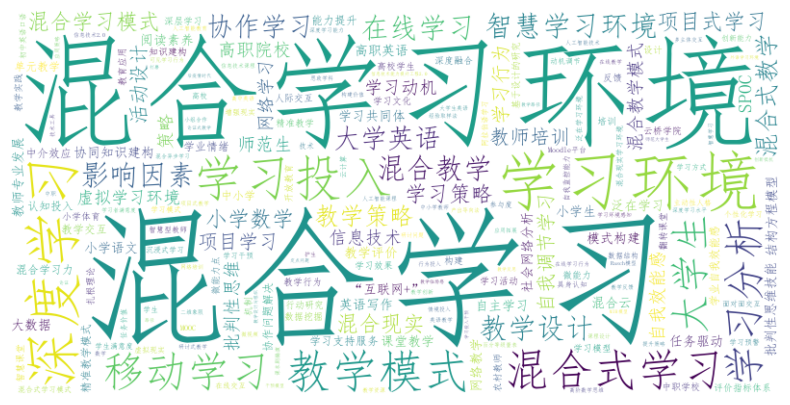

In [13]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 读取CSV文件
file_path = 'literature_info.csv'
df = pd.read_csv(file_path)

# 提取关键词列并统计频率
keywords = df['keywords'].dropna().str.replace(';', '').str.split()
all_keywords = [keyword for sublist in keywords for keyword in sublist]
keyword_counts = Counter(all_keywords)

# 上传字体文件后，指定字体路径
uploaded_font_path = r'C:\Windows\Fonts\simfang.ttf'

# 生成词云图
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=uploaded_font_path).generate_from_frequencies(keyword_counts)

# 显示词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('literature_info.png')
plt.show()


In [19]:
get_ab_key('https://kns.cnki.net/kcms2/article/abstract?v=WnCf0VAm38q7fIsXq-4EH0o9V2nn17qKnGKgMi1OwdxcCY7x7Br7b7FNDAkvCYZc9RIiHGEalP0aGY18JkbIRWPMIIwKQvmddy9gu8iSxBXQcMu6FPImrpxhHIV8tVRIAQgF6IyQIBqyvexMcdC3plq5N8aF8Kb4IBw6XEIKHMTTk8_SsAuTTXVrQtB1obaO&uniplatform=NZKPT&language=CHS')

{'abstract': '目的：观察助卵汤联合盆底电刺激治疗肾虚证DOR的临床疗效，探究在“孙络-微血管”理论指导下如何提高患者卵巢储备功能。方法：选取2022年12月－2023年12月就诊于辽宁中医药大学附属医院妇产科并确诊为肾虚证DOR的患者60例，在患者自愿的基础上选择治疗方案，分为对照组30例，治疗组30例，两组患者均予芬吗通（1/10mg）及助卵汤口服，治疗组在对照组基础上加用盆底生物反馈电刺激治疗方案，两组的疗程均为3个月经周期。比较两组治疗前后的中医证候积分，检测患者血清雌二醇(E2)、卵泡刺激素（FSH）和抗缪勒管激素（AMH），观察患者窦卵泡计数（AFC）、卵巢体积（OV）变化情况，治疗期间记录不良反应发生情况。结果：治疗后治疗组患者的治疗总有效率（90%，27/30），显著高于对照组（56.7%，17/30）；治疗组患者的FSH水平显著低于对照组（P<0.01）；E2水平显著高于对照组（P<0.01）；AFC、OV高于对照组（P<0.05）。结论：基于“孙络－微血管”理论，助卵汤联合盆底电刺激能降低患者中医证候积分，显著改善DOR患者的激素水平，提高卵巢功能。',
 'keywords': '助卵汤; 盆底生物反馈电刺激; 卵巢储备功能减退; 肾虚证;'}